In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
# Path to your JSONL file
jsonl_file_path = r'C:\Users\marco\OneDrive\Desktop\ADV Project\Datasets\all-en.jsonl'

# Function to convert 'date' from YYYYMMDDHHMM to YYYY-MM-DD
def convert_to_date_only(date_int):
    date_str = str(date_int)
    if len(date_str) == 12:  # Ensure it's in the correct format
        date_str = date_str[:8]  # Take the first 8 characters (YYYYMMDD)
        try:
            # Create a Timestamp from the extracted date part
            return pd.Timestamp(year=int(date_str[:4]), month=int(date_str[4:6]), day=int(date_str[6:8]))
        except ValueError:
            # If parsing fails, return NaT
            return pd.NaT
    return pd.NaT  # Return NaT for invalid formats

# Read the JSONL file manually and process it
data = []
with open(jsonl_file_path, 'r') as file:
    for line in file:
        record = json.loads(line.strip())  # Parse each line as a JSON object
        if 'date' in record:
            record['date'] = convert_to_date_only(record['date'])  # Process the date field
        data.append(record)

# Create a DataFrame from the processed data
df_base = pd.DataFrame(data)


In [3]:
# Create the bipartite graph
B = nx.Graph()

# Add nodes for posts and users
# Type = 'user' for users and 'post' for posts
# Add nodes and edges to the bipartite graph
for _, row in df_base.iterrows():
    # Add user node
    user_id = f"user_{row['user_id']}"
    B.add_node(user_id, bipartite='user')
    
    # Add post node
    post_id = f"post_{row['post_id']}"
    B.add_node(post_id, bipartite='post')
    
    # Extract date (month and day) from the 'date' column
    interaction_date = pd.to_datetime(row['date']).strftime('%m-%d')
    
    # Add edge for the post creation
    B.add_edge(user_id, post_id, interaction='created', date=interaction_date)
    
    # Add edges for replies (if present)
    if pd.notna(row['reply_to']):
        replied_post_id = f"post_{int(row['reply_to'])}"
        B.add_edge(user_id, replied_post_id, interaction='replied', date=interaction_date)
    
    # Add edges for reposts (if present)
    if pd.notna(row['repost_from']):
        reposted_post_id = f"post_{int(row['repost_from'])}"
        B.add_edge(user_id, reposted_post_id, interaction='reposted', date=interaction_date)
    
    # Add edges for quotes (if present)
    if pd.notna(row['quotes']):
        quoted_post_id = f"post_{int(row['quotes'])}"
        B.add_edge(user_id, quoted_post_id, interaction='quoted', date=interaction_date)



In [4]:
# Show the number of nodes and edges in the graph
print(f"Number of nodes: {B.number_of_nodes()}")
print(f"Number of edges: {B.number_of_edges()}")

# Display the first 10 edges with their interaction type
print("Example of edges in the bipartite graph with interaction type:")
for u, v, data in list(B.edges(data=True))[:10]:  # show only the first 10
    print(f"{u} -> {v} (interaction: {data['interaction']})")


Number of nodes: 3302488
Number of edges: 4947530
Example of edges in the bipartite graph with interaction type:
user_953571 -> post_3078 (interaction: created)
user_953571 -> post_3079 (interaction: reposted)
user_953571 -> post_3104 (interaction: created)
user_953571 -> post_3105 (interaction: created)
user_953571 -> post_3131 (interaction: created)
user_953571 -> post_3132 (interaction: reposted)
post_3079 -> user_1085289 (interaction: reposted)
post_3079 -> user_233284 (interaction: reposted)
post_3079 -> user_95067 (interaction: quoted)
post_3079 -> user_23826 (interaction: reposted)


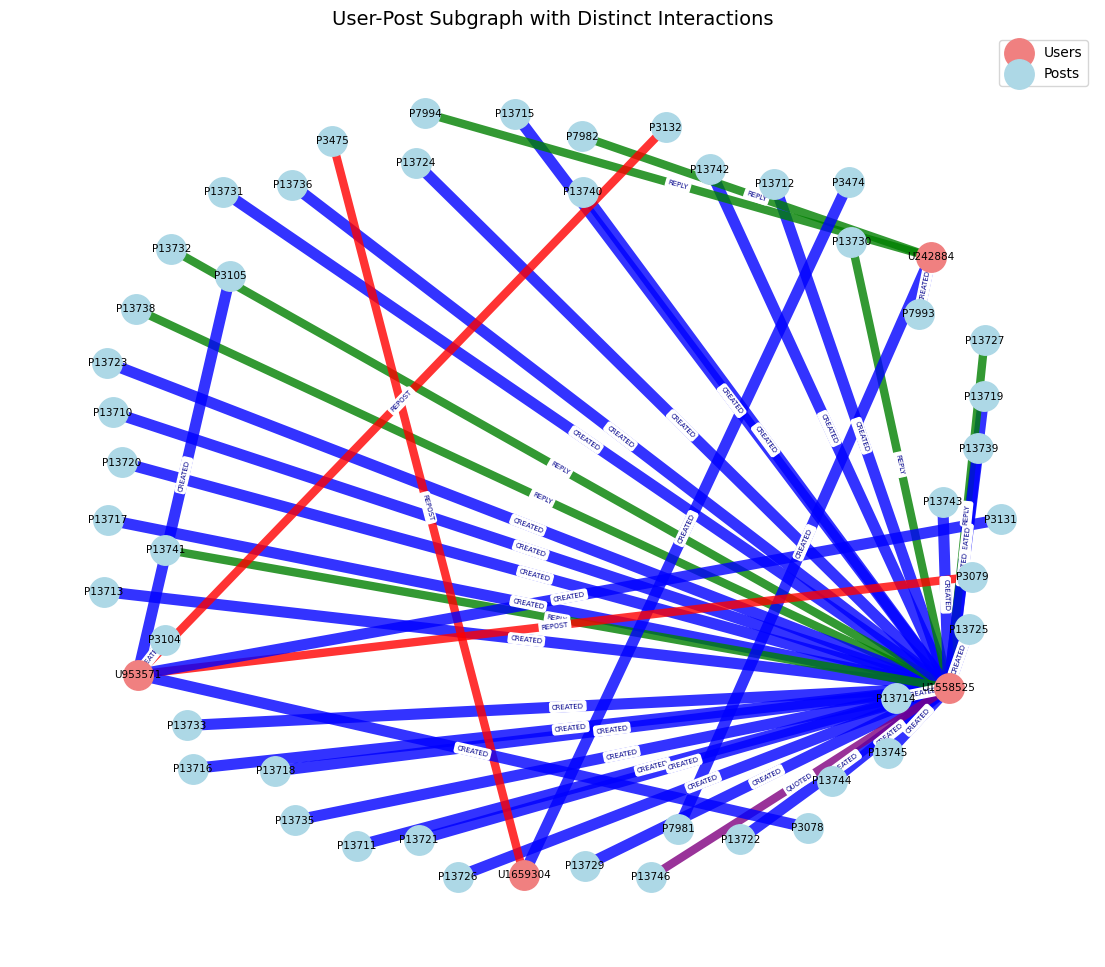

In [5]:
# Define short labels for nodes to improve readability in the visualization
interaction_labels = {
    'created': 'CREATED',  # Abbreviation for Created
    'replied': 'REPLY',    # Abbreviation for Replied
    'reposted': 'REPOST',  # Abbreviation for Reposted
    'quoted': 'QUOTED'     # Abbreviation for Quoted
}

# Extract a subgraph for visualization (e.g., first 50 nodes)
subgraph = B.subgraph(list(B.nodes)[:50])
short_labels = {node: node.replace("user_", "U").replace("post_", "P") for node in subgraph.nodes}

# Recalculate node positions for better readability
pos = nx.spring_layout(subgraph, seed=42, k=15)  # Add 'seed' for a stable layout

# Customize visualization with node sizes and colors
plt.figure(figsize=(14, 12))

# Separate user and post nodes for color distinction
user_nodes = [node for node in subgraph.nodes if node.startswith("user_")]
post_nodes = [node for node in subgraph.nodes if node.startswith("post_")]

# Draw user nodes in one color (e.g., light coral)
user_nodes_drawn = nx.draw_networkx_nodes(subgraph, pos, nodelist=user_nodes, node_color="lightcoral", 
                                          node_size=450, label="Users")

# Draw post nodes in another color (e.g., light blue)
post_nodes_drawn = nx.draw_networkx_nodes(subgraph, pos, nodelist=post_nodes, node_color="lightblue", 
                                          node_size=450, label="Posts")

# Customize edges with variable colors and widths
edge_colors = ["blue" if data["interaction"] == "created" else 
               "green" if data["interaction"] == "replied" else 
               "red" if data["interaction"] == "reposted" else "purple"
               for _, _, data in subgraph.edges(data=True)]

edge_widths = [8 if data["interaction"] == "created" else 
               6 if data["interaction"] == "replied" else 
               6 if data["interaction"] == "reposted" else 6
               for _, _, data in subgraph.edges(data=True)]

edges_drawn = nx.draw_networkx_edges(subgraph, pos, edge_color=edge_colors, width=edge_widths, alpha=0.8)

# Add interaction labels using abbreviations
edge_labels = {(u, v): interaction_labels[data['interaction']] for u, v, data in subgraph.edges(data=True)}
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=5, font_color="darkblue")

# Add labels to nodes
nx.draw_networkx_labels(subgraph, pos, labels=short_labels, font_size=7.5, font_color="black")

# Add a legend
plt.legend(
    [user_nodes_drawn, post_nodes_drawn],
    ["Users", "Posts"],
    loc="upper right",
    fontsize=10
)

# Add title and remove axes
plt.title("User-Post Subgraph with Distinct Interactions", fontsize=14)
plt.axis("off")

# Save the graph visualization as an image
plt.savefig("user_post_subgraph.png", format="png", dpi=300)

# Display the plot
plt.show()


In [6]:
# Extract all edges from the graph
edges_data = []

for u, v, data in B.edges(data=True):
    # Identify user and post nodes
    if 'user' in u:
        user_node = u
        post_node = v
    else:
        user_node = v
        post_node = u

    # Append edge information to the list
    edges_data.append({
        'user_id': user_node.replace("user_", ""),
        'post_id': post_node.replace("post_", ""),
        'interaction': data['interaction'],
        'date': data['date']  # Include the date attribute
    })

# Create a DataFrame from the edge data
df_edges = pd.DataFrame(edges_data)

# Save the DataFrame to a file
df_edges.to_csv("graph_edges_TM.csv", index=False)

print("Edges DataFrame saved as bipartite_edges.csv")


Edges DataFrame saved as bipartite_edges.csv
